In [2]:
import Pkg
Pkg.activate(dirname(@__DIR__))
Pkg.instantiate()

  Activating project at `~/Teaching/BEE4850/website/slides`


In [58]:
using Distributions
using StatsBase
using CSV
using DataFrames
using Optim
using Turing
using Plots
using StatsPlots
using DifferentialEquations


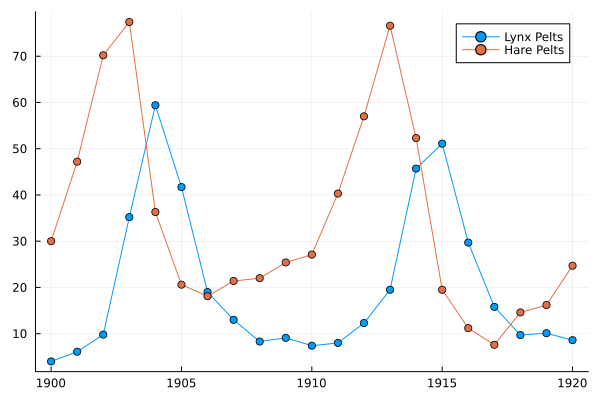

In [10]:
dat_path = joinpath(@__DIR__, "..", "data", "ecology")

dat = CSV.read(joinpath(dat_path, "Lynx_Hare.csv"), DataFrame, delim=";")
plot(dat.Year, dat.Lynx, markershape=:circle, label="Lynx Pelts")
plot!(dat.Year, dat.Hare, markershape=:circle, label="Hare Pelts")

In [21]:
function sim_lynx_hare(p, T, dt=.002)
    H₀, L₀, bh, mh, bl, ml = p
    n_steps = Int64(T / dt)
    L = zeros(n_steps)
    H = zeros(n_steps)
    H[1] = H₀
    L[1] = L₀
    for i ∈ 2:n_steps
        H[i] = H[i-1] + dt * H[i-1] * (bh - mh * L[i-1])
        L[i] = L[i-1] + dt * L[i-1] * (bl * H[i-1] - ml)
    end
    return (L, H)
end

sim_lynx_hare (generic function with 2 methods)

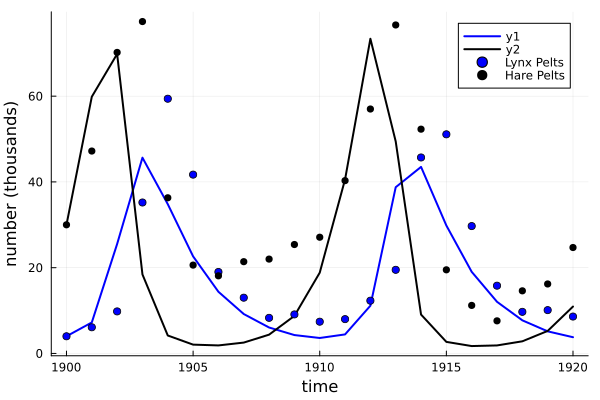

In [44]:
θ = [dat.Hare[1], dat.Lynx[1], 1.0, 0.06, 0.025, 0.5]
z = sim_lynx_hare(θ, 21, 0.01);

plot(1900:1920, z[1][1:100:end], lw=2, xlab="time", ylab="number (thousands)", c=:blue)
plot!(1900:1920, z[2][1:100:end], lw=2, c=:black)

scatter!(dat.Year, dat.Lynx, markershape=:circle, label="Lynx Pelts", c=:blue)
scatter!(dat.Year, dat.Hare, markershape=:circle, label="Hare Pelts", c=:black)

In [51]:
function lh_loglik(p, lynx_pop, hare_pop, T, dt)
    H₀, L₀, bh, mh, bl, ml, ch, cl, σh, σl = p
    t_step = Int64(1 / dt)
    n_steps = T * t_step

    L, H = sim_lynx_hare(p[1:6], T, dt)  
    μL = cl * L[1:t_step:n_steps]
    μH = ch * H[1:t_step:n_steps]  
    if all(μL .> 0.0) && all(μH .> 0.0)
        ll = sum(logpdf.(LogNormal.(log.(μL), σl), lynx_pop)) + sum(logpdf.(LogNormal.(log.(μH), σh), hare_pop))
    else
        ll = -Inf
    end
    return ll
end

lh_loglik (generic function with 1 method)

In [78]:
lb = [100.0, 20.0, 0.3, 0.05, 0.005, 0.1, 0.15, 0.15, 0.1, 0.1]
ub = [200.0, 100.0, 0.4, 0.1, 0.02, 1.0, 0.25, 0.25, 1.0, 1.0]
p0 = [150.0, 25.0, 0.35, 0.07, 0.01, 0.5, 0.2, 0.2, 0.5, 0.5]

optim_out = Optim.optimize(p -> -lh_loglik(p, dat.Lynx, dat.Hare, 21, .002), lb, ub, p0)

 * Status: success

 * Candidate solution
    Final objective value:     2.280747e+02

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.75e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    9
    f(x) calls:    2363
    ∇f(x) calls:   2363


In [79]:
θ = optim_out.minimizer

10-element Vector{Float64}:
 142.93594006117735
  20.000000000000004
   0.39999999999999997
   0.05000000000000001
   0.005000000000000001
   0.5806621798033957
   0.24999999999999997
   0.24999999999999997
   0.7402041835543648
   0.9999999999999999

In [63]:
function lynx_hare!(dLH, LH, θ, t)
    L, H = LH
    bh, mh, bl, ml = θ

    dLH[1] = dL = (bl * H - ml) * L
    dLH[2] = dH = (bh - mh * L) * H
end

@model function lynx_hare_model(N, L, H)
    b_h ~ truncated(Normal(1, 0.5), 0.0, Inf)
    b_l ~ truncated(Normal(0.05, 0.05), 0.0, Inf)
    m_h ~ truncated(Normal(0.05, 0.05), 0.0, Inf)
    m_l ~ truncated(Normal(1, 0.5), 0.0, Inf)
    
    σ_h ~ Exponential()
    σ_l ~ Exponential()
    h₁ ~ LogNormal(log(10), 1)
    l₁ ~ LogNormal(log(10), 1)
    p_h ~ Beta(40, 200)
    p_l ~ Beta(40, 200)
    
    LH₁ = [l₁, h₁]
    θ = [b_h, m_h, b_l, m_l]
    prob = ODEProblem(lynx_hare!, LH₁, N-1, θ)
    sol = solve(prob, saveat=1)
    if length(sol.u) < N
        Turing.@addlogprob! -Inf
    else
        μ_l = map(first, sol.u[1:N]) .* p_l
        μ_h = map(last, sol.u[1:N]) .* p_h
        # sometime solution might end up with negative population :)
        if all(μ_l .> 0.0) && all(μ_h .> 0.0)
            logμ_l = log.(μ_l)
            logμ_h = log.(μ_h)
            @. L ~ LogNormal(logμ_l, σ_l)
            @. H ~ LogNormal(logμ_h, σ_h)
        else
            Turing.@addlogprob! -Inf
        end
    end
end

lynx_hare_model (generic function with 2 methods)

In [64]:
mod = lynx_hare_model(nrow(dat), dat.Lynx, dat.Hare)
lh_mle = maximum_likelihood(mod)

┌ Warning: At t=3.52035193223946e-161, dt was forced below floating point epsilon 3.9484127069845653e-177, and step error estimate = NaN. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of ForwardDiff.Dual{ForwardDiff.Tag{DifferentiationInterface.FixTail{LogDensityFunction{DynamicPPL.TypedVarInfo{@NamedTuple{b_h::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b_h, typeof(identity)}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64, Float64, Float64}}, Vector{AbstractPPL.VarName{:b_h, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, b_l::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:b_l, typeof(identity)}, Int64}, Vector{Truncated{Normal{Float64}, Continuous, Float64, Float64, Float64}}, Vector{AbstractPPL.VarName{:b_l, typeof(identity)}}, Vector{Float64}, Vector{Set{DynamicPPL.Selector}}}, m_h::DynamicPPL.Metadata{Dict{AbstractPPL.VarName{:m_h

ModeResult with maximized lp of -170.67
[0.3321708747690329, 0.08934006136999731, 0.007644898853031351, 14.94461141299985, 0.6215126452405715, 0.7519073634125419, 167.58257242403613, 39.74933008884732, 0.16890383246709387, 0.3476173002656148]

In [65]:
lh_map = maximum_a_posteriori(mod)

ModeResult with maximized lp of -174.45
[1.0245238615390608, 0.007551115364920718, 0.011496498093974062, 1.1817523104565646, 0.5700912872806648, 0.6602891821613094, 110.87231227189477, 61.78554325338345, 0.17609946073814878, 0.17426750829146895]